In [1]:
import os
import graphviz
from sklearn.tree import export_graphviz
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
import numpy as np
#print(os.getcwd())
#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')

## Processing

In [2]:
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv',index=False)
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')     

X = usableCSV.drop(columns=['Diagnosis'])
y = usableCSV['Diagnosis']

categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Test Split


In [3]:
''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Training

In [4]:
results = {}

''' ----------- Logistic Model Training ----------- '''
log = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l2', C=1.0, solver='liblinear')
log.fit(X_train, y_train)
results['LogisticRegression'] = {'model':log,
                                 'accuracy':accuracy_score(y_test, log.predict(X_test)), 
                                 'y_prob':log.predict_proba(X_test), 
                                 'y_pred':log.predict(X_test), 
                                 'y_prob_class1':log.predict_proba(X_test)[:, 1], 
                                 'plot_pos':(0,0,'Logistic Regression'),
                                 'mse': mean_squared_error(y_test, log.predict(X_test))}

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier(random_state=2028, max_depth= 5, min_samples_leaf= 4, min_samples_split= 10) # 93.02 = 2028
tree.fit(X_train, y_train)
results['DecisionTree'] = {'model':tree,
                           'accuracy':accuracy_score(y_test, tree.predict(X_test)), 
                           'y_prob':tree.predict_proba(X_test), 
                           'y_pred':tree.predict(X_test), 
                           'y_prob_class1':tree.predict_proba(X_test)[:, 1], 
                           'plot_pos':(0,1,'Decision Tree'),
                           'mse': mean_squared_error(y_test, tree.predict(X_test))}

'''------------ Random Forest Model Training---------'''
forest = RandomForestClassifier(max_features='sqrt', n_estimators=len(X_train), random_state=42, max_depth=14) # 95.12 at md = 14
forest.fit(X_train, y_train)
results['RandomForest'] = {'model':forest,
                           'accuracy':accuracy_score(y_test, forest.predict(X_test)), 
                           'y_prob':forest.predict_proba(X_test), 
                           'y_pred':forest.predict(X_test), 
                           'y_prob_class1':forest.predict_proba(X_test)[:, 1], 
                           'plot_pos':(0,2,'Random Forest'),
                            'mse': mean_squared_error(y_test, forest.predict(X_test))}

'''----------------Hist Gradient Boost Training--------'''
histGradient = HistGradientBoostingClassifier(l2_regularization= 0, learning_rate= 0.1, max_depth= 3, max_iter= 100)
histGradient.fit(X_train, y_train)
results['HistGradientBoost'] = {'model':histGradient,
                                'accuracy':accuracy_score(y_test, histGradient.predict(X_test)), 
                                'y_prob':histGradient.predict_proba(X_test), 
                                'y_pred':histGradient.predict(X_test), 
                                'y_prob_class1':histGradient.predict_proba(X_test)[:, 1], 
                                'plot_pos':(1,0,'Hist Gradient Boost'),
                                 'mse': mean_squared_error(y_test, histGradient.predict(X_test))}

'''----------------XG Boost Training-------------------------'''
xgBoost = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0)
xgBoost.fit(X_train, y_train)
results['XGBoost'] = {'model':xgBoost,
                      'accuracy':accuracy_score(y_test, xgBoost.predict(X_test)), 
                      'y_prob':xgBoost.predict_proba(X_test), 
                      'y_pred':xgBoost.predict(X_test), 
                      'y_prob_class1':xgBoost.predict_proba(X_test)[:, 1], 
                      'plot_pos':(1,1,'XGBoost'),
                      'mse': mean_squared_error(y_test, xgBoost.predict(X_test))}

for model_name, metrics in results.items():
    print(f"{model_name}: \n        Accuracy: {metrics['accuracy'] * 100:.2f}%\n        MSE: {metrics['mse']}")

LogisticRegression: 
        Accuracy: 81.40%
        MSE: 0.18604651162790697
DecisionTree: 
        Accuracy: 93.49%
        MSE: 0.06511627906976744
RandomForest: 
        Accuracy: 95.12%
        MSE: 0.04883720930232558
HistGradientBoost: 
        Accuracy: 95.58%
        MSE: 0.044186046511627906
XGBoost: 
        Accuracy: 95.35%
        MSE: 0.046511627906976744


In [5]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
import time

param_grids = {
    'LogisticRegression': {'penalty': ['l2'],'C': [0.01, 0.1, 1, 10],'solver': ['liblinear', 'saga']},
    'DecisionTree': {'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]},
    'RandomForest': {'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5],'max_features': ['sqrt', 'log2']},
    'HistGradientBoost': {'learning_rate': [0.01, 0.1, 0.2],'max_iter': [100, 200],'max_depth': [3, 5, 7],'l2_regularization': [0, 0.1]},
    'XGBoost': {'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7],'learning_rate': [0.01, 0.1, 0.2],'subsample': [0.8, 0.9, 1.0]}
}

models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'HistGradientBoost': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

best_models = {}
best_params = {}

for model_name, model in models.items():
    print(f"\n=== Tuning {model_name} ===")
    start_time = time.time()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
    print(f"Time elapsed: {time.time() - start_time:.2f} seconds")

print("\n=== Best Models ===")
for model_name, model in best_models.items():
    print(f"{model_name}: {model}")'''

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier\nfrom xgboost import XGBClassifier\nimport time\n\nparam_grids = {\n    \'LogisticRegression\': {\'penalty\': [\'l2\'],\'C\': [0.01, 0.1, 1, 10],\'solver\': [\'liblinear\', \'saga\']},\n    \'DecisionTree\': {\'max_depth\': [3, 5, 7, None],\'min_samples_split\': [2, 5, 10],\'min_samples_leaf\': [1, 2, 4]},\n    \'RandomForest\': {\'n_estimators\': [50, 100, 200],\'max_depth\': [3, 5, 7, None],\'min_samples_split\': [2, 5],\'max_features\': [\'sqrt\', \'log2\']},\n    \'HistGradientBoost\': {\'learning_rate\': [0.01, 0.1, 0.2],\'max_iter\': [100, 200],\'max_depth\': [3, 5, 7],\'l2_regularization\': [0, 0.1]},\n    \'XGBoost\': {\'n_estimators\': [50, 100, 200],\'max_depth\': [3, 5, 7],\'learning_rate\': [0.01, 0.1, 0.2],\'subsample\': [0.8, 0.9, 1.0]}\n}

## Analysis

K-Fold Cross Validation

In [6]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for model_name, metrics in results.items():
    if model_name == 'XGBoost':
        metrics['model'].set_params(tree_method='gpu_hist', gpu_id=0)
    scores = cross_val_score(metrics['model'], X_scaled, y, cv=kf, scoring='accuracy', n_jobs=-1)
    metrics['cross_val_score_mean'] = scores.mean()
    results[model_name]['k-fold'] = metrics["cross_val_score_mean"] * 100
    print(f'Cross-validated {model_name} accuracy: {metrics["cross_val_score_mean"] * 100:.2f}%')

Cross-validated LogisticRegression accuracy: 82.13%
Cross-validated DecisionTree accuracy: 94.83%
Cross-validated RandomForest accuracy: 95.07%
Cross-validated HistGradientBoost accuracy: 95.11%
Cross-validated XGBoost accuracy: 95.44%


## Visualization

### Decision Tree Plot

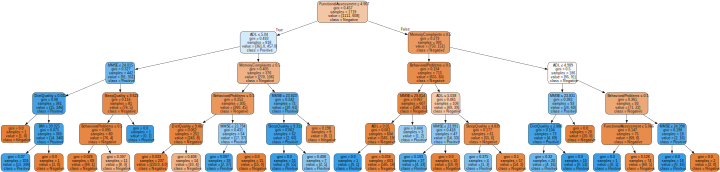

In [7]:
tree = DecisionTreeClassifier(random_state=2028, max_depth=5, min_samples_split=10) # 93.02 = 2028
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
tree.fit(X_train, y_train)
dot_data = export_graphviz(tree,out_file = None,
                           feature_names=X.columns,
                           class_names=['Negative','Positive'],
                           filled=True, rounded=True,
                           special_characters=True)
dot_data = 'digraph Tree {\nsize="10,10";\n' + '\n'.join(dot_data.split('\n')[1:])
d_tree_Comprehensible = graphviz.Source(dot_data)


#d_tree_Comprehensible.set_size('"5,10!"')

#display(d_tree_ZScore)
display(d_tree_Comprehensible)

#print(dot_data)
#dot_data = graphviz.Digraph(graph_attr={'size':'10,10!'})
#print(dot_data)

### Confusion Matrices

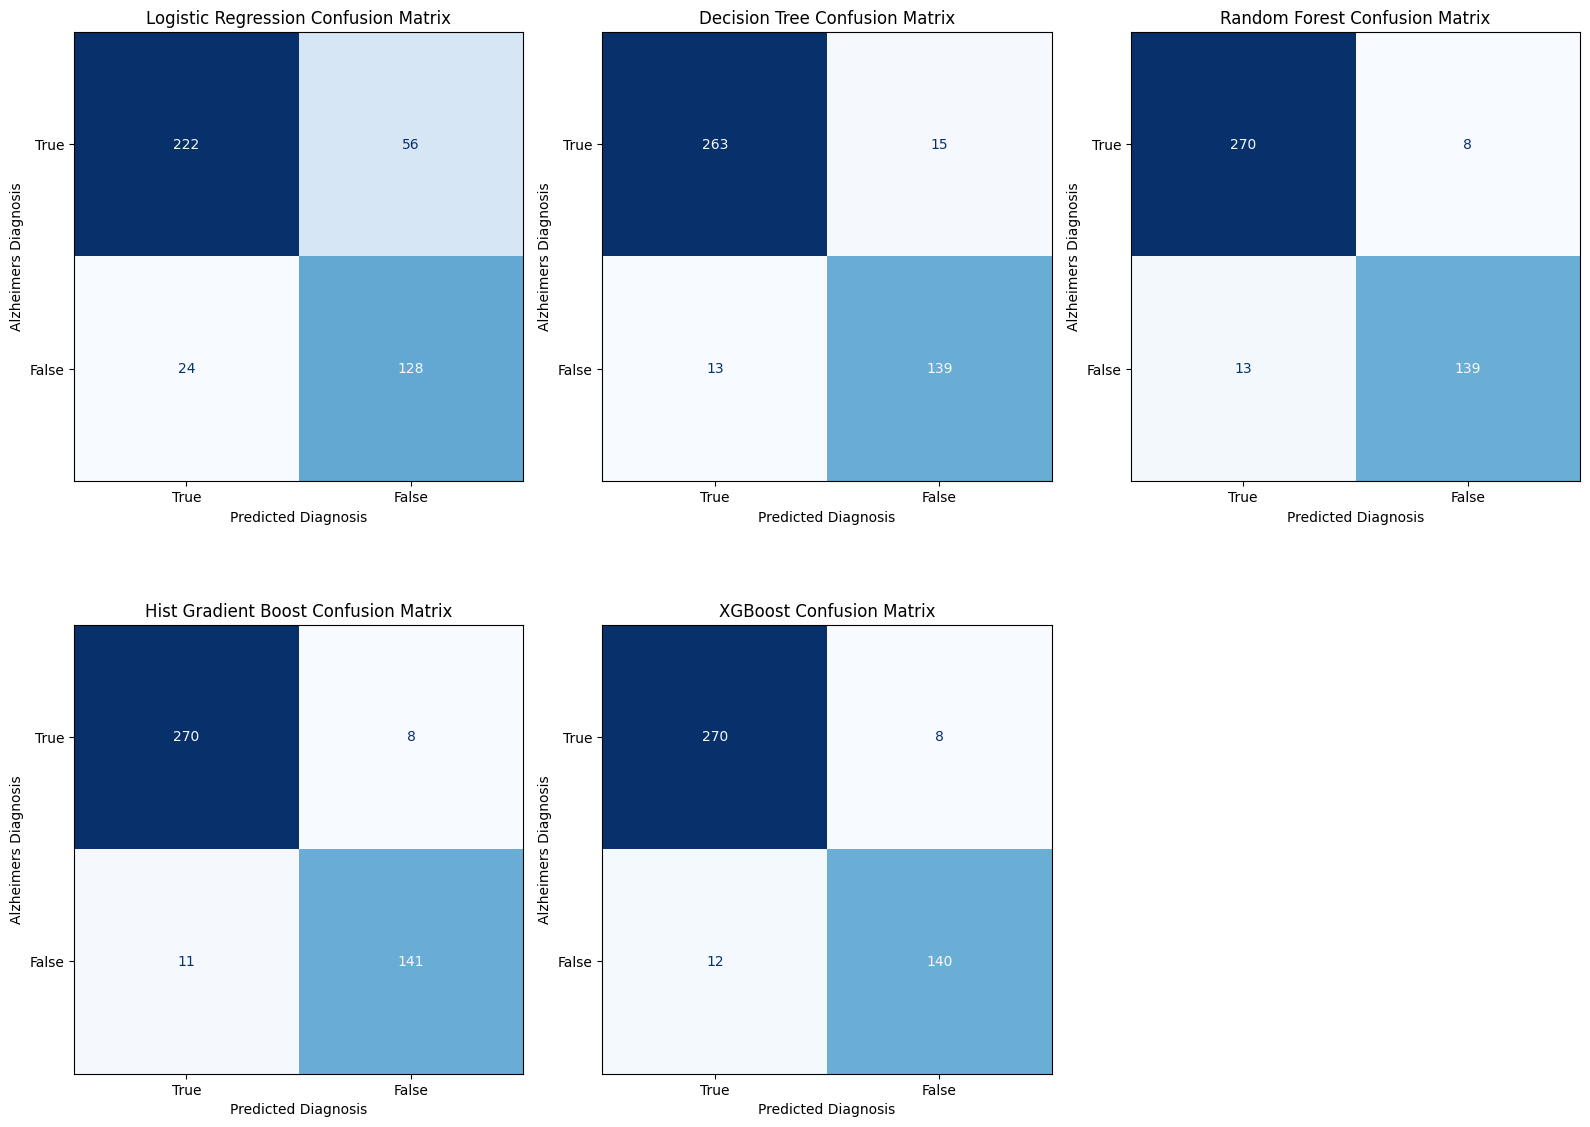

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for model_name, metrics in results.items():
    row, col, title = metrics['plot_pos']
    y_pred = metrics['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
    disp.plot(ax=axes[row][col], colorbar=False, cmap="Blues")
    axes[row][col].set_title(f"{title} Confusion Matrix")
    axes[row][col].set_ylabel("Alzheimers Diagnosis")
    axes[row][col].set_xlabel("Predicted Diagnosis")
fig.delaxes(axes[1][2])
plt.tight_layout()
plt.show()

### Classification Reports

In [9]:
for model_name, metrics in results.items():
    metrics['report'] = classification_report(y_test, metrics['y_pred'])
    
for model_name, metrics in results.items():
    print(f"{model_name} Classification Report:")
    print(metrics['report'])
    print('-' * 53)
    
#Logistic Regression Importance Values
'''
coefficients = log.coef_[0]
feat_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
feat_df['AbsCoefficient'] = feat_df['Coefficient'].abs()
feat_df = feat_df.sort_values(by='AbsCoefficient', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients (Logistic Regression)')
plt.show()
'''

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430

-----------------------------------------------------
DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       278
           1       0.90      0.91      0.91       152

    accuracy                           0.93       430
   macro avg       0.93      0.93      0.93       430
weighted avg       0.94      0.93      0.93       430

-----------------------------------------------------
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1   

"\ncoefficients = log.coef_[0]\nfeat_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})\nfeat_df['AbsCoefficient'] = feat_df['Coefficient'].abs()\nfeat_df = feat_df.sort_values(by='AbsCoefficient', ascending=True)\nplt.figure(figsize=(10, 6))\nplt.barh(feat_df['Feature'], feat_df['Coefficient'])\nplt.xlabel('Coefficient Value')\nplt.title('Feature Coefficients (Logistic Regression)')\nplt.show()\n"

### Receiver Operating Characteristic Curves

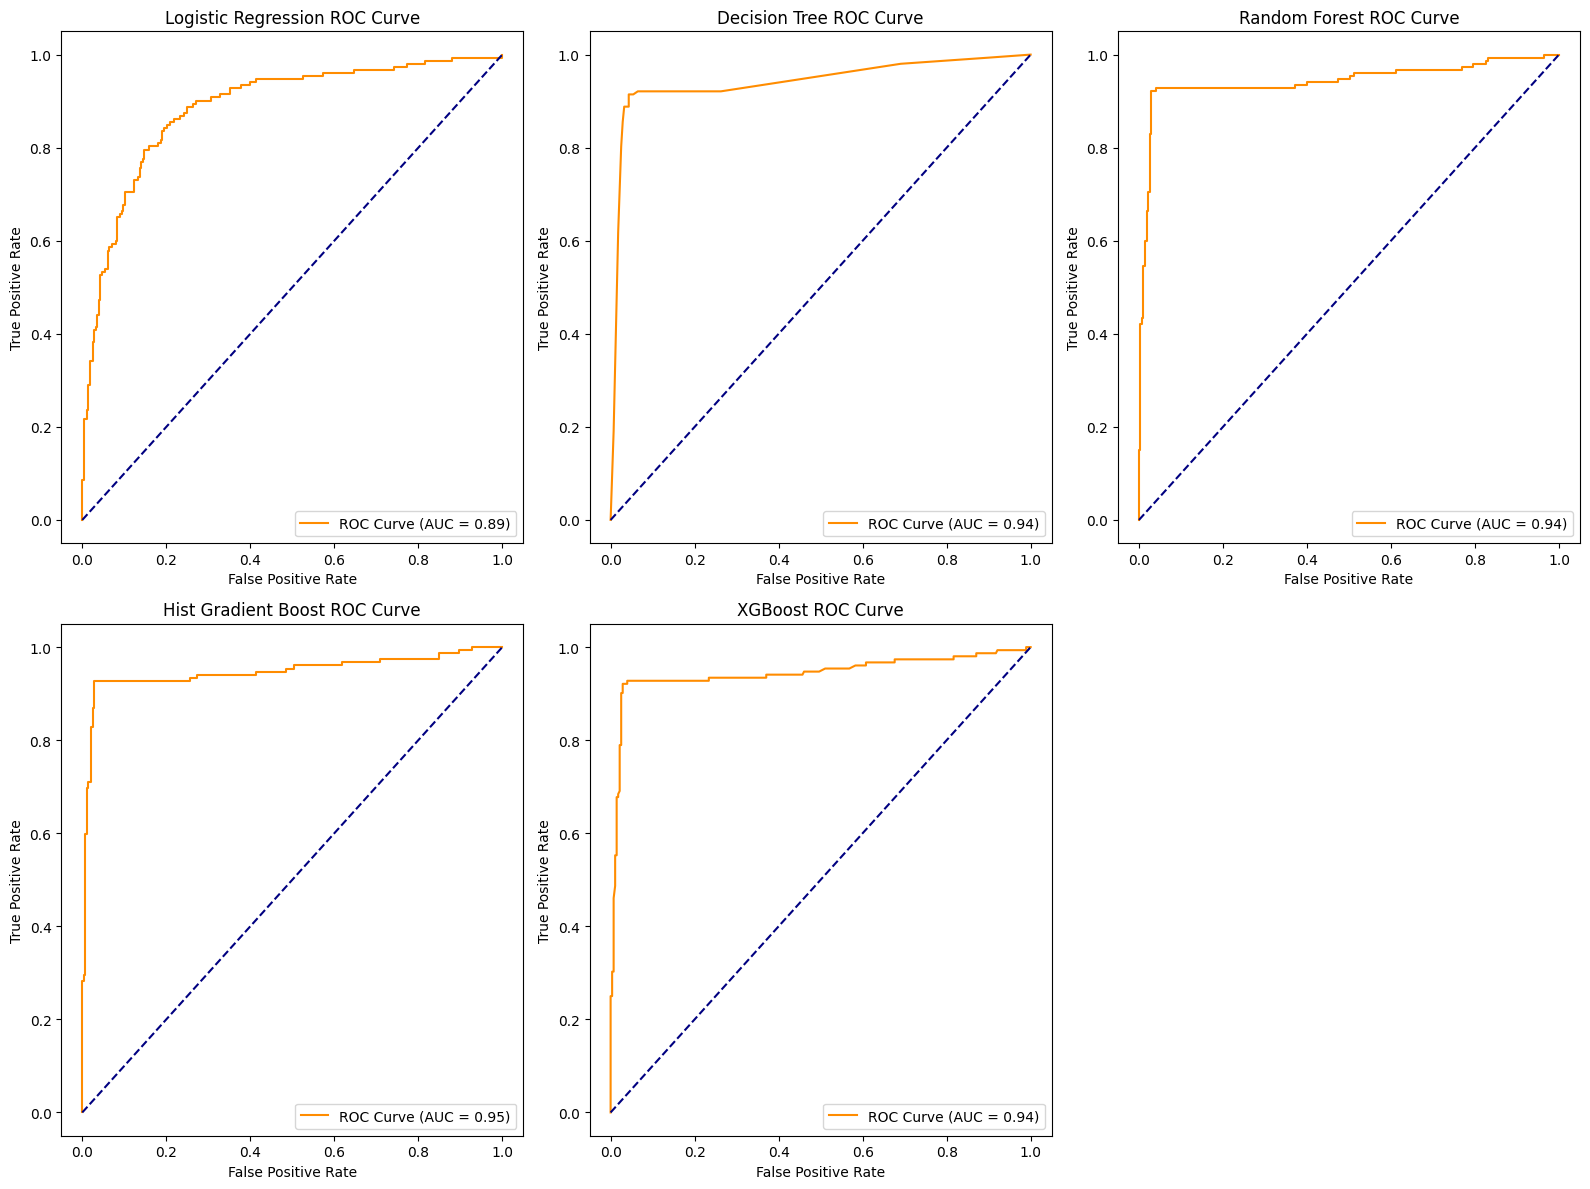

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for model_name, metrics in results.items():
    row, col, title = metrics['plot_pos']
    y_prob = metrics['y_prob_class1']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axes[row][col].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
    axes[row][col].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[row][col].set_xlabel('False Positive Rate')
    axes[row][col].set_ylabel('True Positive Rate')
    axes[row][col].set_title(f'{title} ROC Curve')
    axes[row][col].legend(loc="lower right")
fig.delaxes(axes[1][2])

plt.tight_layout()
plt.show()

## Best Model!

In [11]:
best_model = None
best_model_accuracy = -1

for model_name in results:
    if(results[model_name]["k-fold"] > best_model_accuracy):
        best_model = model_name
        best_model_accuracy = results[model_name]["k-fold"]
msgt = f'The best model after K-Fold Cross Validation 5, is {best_model} with an accuracy of {best_model_accuracy:.2f}%'
hw = len(msgt)
msgb = f'------Model Accuracy Rankings------'
print(f"{msgt}\n{msgb.center(hw)}")
ranks = []
for model_name in results:
    ranks.append((model_name, results[model_name]["k-fold"]))
for i in range(1, len(ranks)):
    j=i
    while j>0 and ranks[j][1] > ranks[j-1][1]:
        ranks[j], ranks[j-1] = ranks[j-1], ranks[j]
        j-=1
max_len = 0
for things in ranks:
    if(len(things[0]) > max_len):
        max_len = len(things[0])
for rank in ranks:
    msg = (f"{rank[0]:<{max_len}}|| {f'{rank[1]:.2f}%':>14}")
    print(msg.center(hw))
filler = ''
for i in range(len(msgb)):
    filler+="-"
print(filler.center(hw))

The best model after K-Fold Cross Validation 5, is XGBoost with an accuracy of 95.44%
                         ------Model Accuracy Rankings------                         
                         XGBoost           ||         95.44%                         
                         HistGradientBoost ||         95.11%                         
                         RandomForest      ||         95.07%                         
                         DecisionTree      ||         94.83%                         
                         LogisticRegression||         82.13%                         
                         -----------------------------------                         


## Model Fun

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def sequential_feature_risk_profile(model, scaler, X, num_points=50):
    """
    Plots risk profiles one at a time, prompting user to continue or stop.
    """
    # Create median patient profile
    median_patient = X.median().values.reshape(1, -1)
    
    # Show available features
    print("Available features:")
    for i, feature in enumerate(X.columns):
        print(f"{i+1}. {feature}")
    
    while True:
        try:
            # Get user input for feature selection
            selection = input("\nEnter feature number to plot (or 'q' to quit): ")
            if selection.lower() == 'q':
                break
                
            feature_idx = int(selection) - 1
            if feature_idx < 0 or feature_idx >= len(X.columns):
                print("Invalid feature number. Please try again.")
                continue
                
            feature_name = X.columns[feature_idx]
            
            plt.figure(figsize=(10, 6))
            
            # Create range of values for current feature
            feat_min = X[feature_name].min()
            feat_max = X[feature_name].max()
            feat_values = np.linspace(feat_min, feat_max, num_points)
            
            # Create test patients - vary only current feature
            test_patients = np.tile(median_patient, (num_points, 1))
            test_patients[:, feature_idx] = feat_values
            
            # Convert back to DataFrame to preserve feature names
            test_df = pd.DataFrame(test_patients, columns=X.columns)
            
            # Scale and predict
            scaled_data = scaler.transform(test_df)
            probs = model.predict_proba(scaled_data)[:, 1]
            probs_smooth = gaussian_filter1d(probs, sigma=2)
            # Plot
            plt.plot(feat_values, probs, color='darkred', linewidth=2)
            plt.title(f'Alzheimer\'s Risk vs. {feature_name}')
            plt.xlabel(feature_name)
            plt.ylabel('Predicted Probability')
            plt.axvline(x=median_patient[0, feature_idx], color='gray', linestyle='--', label='Median Value')
            plt.grid(True)
            plt.legend()
            plt.show()
            
        except ValueError:
            print("Please enter a valid number or 'q' to quit.")

# Usage
sequential_feature_risk_profile(results[best_model]["model"], scaler, X)

Available features:
1. Age
2. EducationLevel
3. BMI
4. Smoking
5. AlcoholConsumption
6. PhysicalActivity
7. DietQuality
8. SleepQuality
9. HeadInjury
10. Hypertension
11. CholesterolTotal
12. CholesterolLDL
13. CholesterolHDL
14. CholesterolTriglycerides
15. MMSE
16. FunctionalAssessment
17. MemoryComplaints
18. BehavioralProblems
19. ADL
20. Confusion
21. Disorientation
22. PersonalityChanges
23. DifficultyCompletingTasks
24. Forgetfulness
25. Gender_1
26. Ethnicity_1
27. Ethnicity_2
28. Ethnicity_3
29. FamilyHistoryAlzheimers_1


## Unsupervised Learning

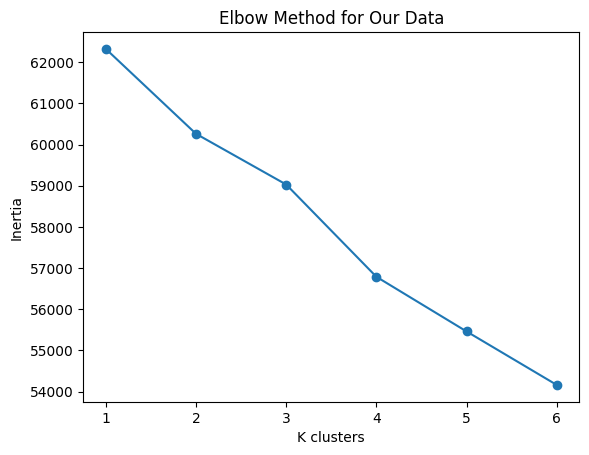

C:\Users\cjold\AppData\Local\Temp\ipykernel_17688\185681896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xc['cluster'] = clusters


               Age  EducationLevel        BMI  AlcoholConsumption  \
cluster                                                             
0        74.849153        1.276271  27.084378           10.210332   
1        75.544776        0.967662  30.528032           10.163540   
2        74.278146        1.634437  25.043407            9.773746   

         PhysicalActivity  DietQuality  SleepQuality  CholesterolTotal  \
cluster                                                                  
0                4.940980     5.258269      7.044328        222.781027   
1                5.218520     4.858233      6.620368        227.900538   
2                4.586287     4.929609      7.515025        224.207457   

         CholesterolLDL  CholesterolHDL  CholesterolTriglycerides       MMSE  \
cluster                                                                        
0            124.654989       57.508037                221.869968  15.125565   
1            117.083556       61.791330    

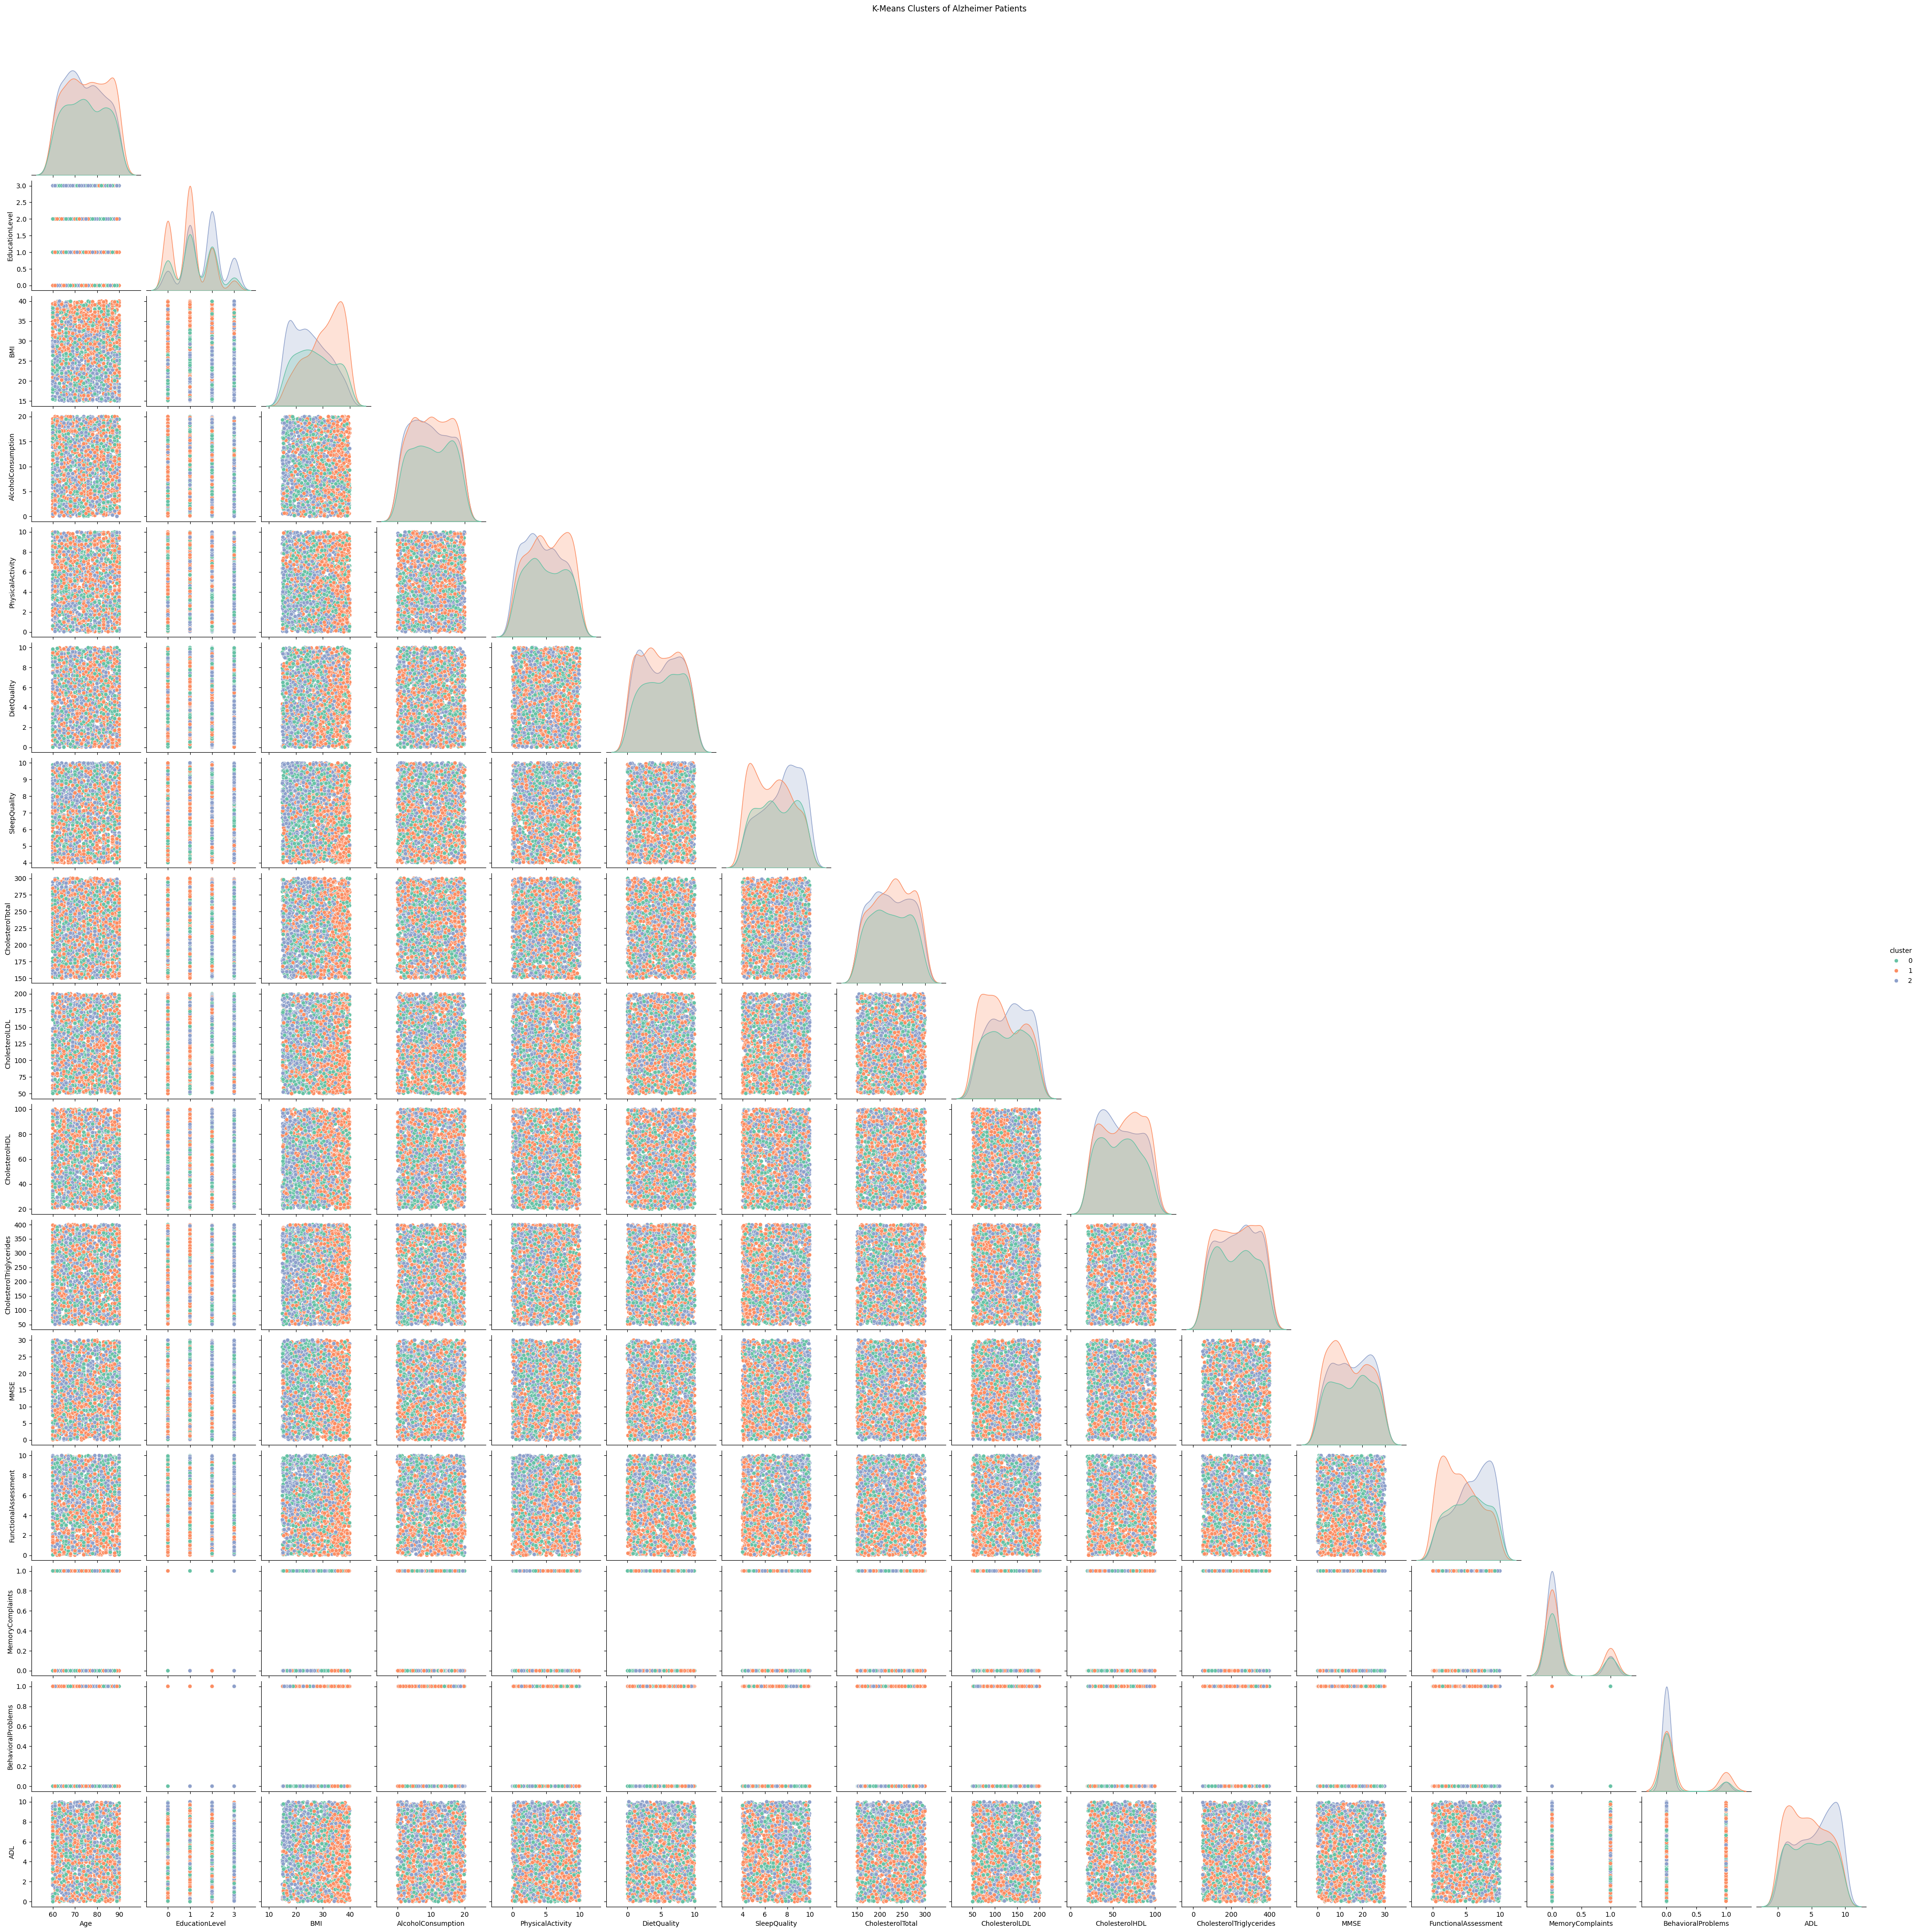

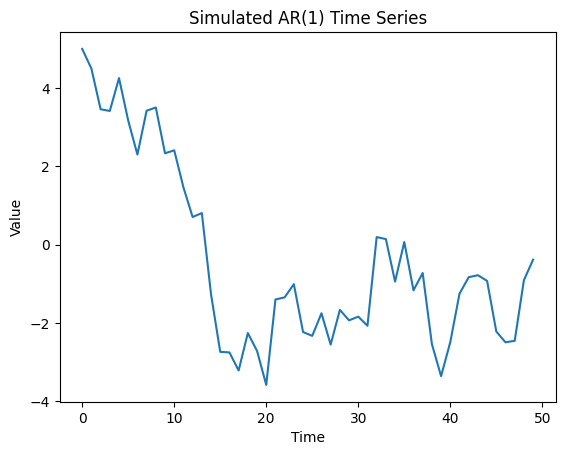

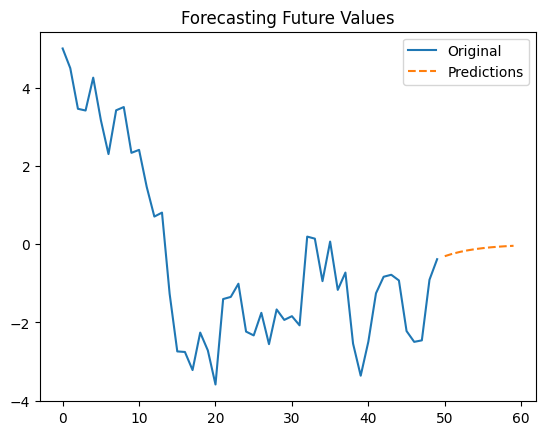

"from sklearn.decomposition import PCA\nfrom sklearn.cluster import DBSCAN, KMeans\n\n\n\n\n\n\nfrom sklearn.neighbors import NearestNeighbors\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nk = 12\n\nnearest_neighbors = NearestNeighbors(n_neighbors=k)\nneighbors = nearest_neighbors.fit(X_scaled)\ndistances, indices = neighbors.kneighbors(X_scaled)\ndistances = np.sort(distances[:, k - 1], axis=0)\nplt.figure(figsize=(10, 5))\nplt.plot(distances)\nplt.title('k-distance Graph')\nplt.ylabel(f'Distance to {k}th nearest neighbor')\nplt.xlabel('Points sorted by distance')\nplt.grid(True)\nplt.show()\n############\ndf = usableCSV[['Age', 'EducationLevel', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']]\n############\n\n\n\ndb = DBSCAN(eps=2.6, min_samples=7)\n\ndf = usableCSV[['Age', 'BMI'

In [ ]:
'''from sklearn.cluster import KMeans

Xc = usableCSV[['Age', 'EducationLevel', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']]


inertia = []
for k in range(1, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1,7), inertia, marker='o')
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Our Data')
plt.show()

# Choose K based on elbow (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
Xc['cluster'] = clusters

# Analyze clusters
print(Xc.groupby('cluster').mean())


import matplotlib.pyplot as plt
import seaborn as sns

X_vis = Xc.copy()
X_vis['cluster'] = clusters

# 2D visualization with pairplot
sns.pairplot(X_vis, hue='cluster', palette='Set2', corner=True)
plt.suptitle('K-Means Clusters of Alzheimer Patients', y=1.02)
plt.show()


np.random.seed(42)
n = 50
y = [5]  # start value
for t in range(1, n):
    y.append(0.8 * y[t-1] + np.random.normal(0, 1))  # AR(1): y_t = 0.8*y_{t-1} + noise

plt.plot(y)
plt.title("Simulated AR(1) Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()



def predict_next(y_values, weight):
    return weight * y_values[-1]

# Start predictions with last known value

w=0.8
predictions = [y[-1]]
for _ in range(10):
    next_val = predict_next(predictions, w)
    predictions.append(next_val)

# Drop the starting point for plotting predicted values
predicted_y = predictions[1:]  # exclude y[-1], already in original y

# Plot actual data
plt.plot(range(len(y)), y, label="Original")

# Plot predictions starting from len(y)
plt.plot(range(len(y), len(y) + len(predicted_y)), predicted_y, label="Predictions", linestyle="--")

plt.title("Forecasting Future Values")
plt.legend()
plt.show()
'''


'''from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans






from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 12

nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, k - 1], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('k-distance Graph')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()
############
df = usableCSV[['Age', 'EducationLevel', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']]
############



db = DBSCAN(eps=2.6, min_samples=7)

df = usableCSV[['Age', 'BMI', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints','BehavioralProblems', 'ADL', 'Diagnosis']]
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df)

db_labels = db.fit_predict(X_scaled)
labels = db_labels
pca_2 = PCA(n_components=2)
data_pca = pca_2.fit_transform(X_scaled)
unique_labels = set(labels)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')
plt.figure(figsize=(10, 10))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=db_labels, cmap='rainbow', s=30)

plt.title('DBSCAN Clustering with PCA-reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


df = usableCSV[['Age', 'EducationLevel', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']]
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df)



pca = PCA(n_components=2)
data_ss = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(data_ss)
kmeans.cluster_centers_
centroids = kmeans.cluster_centers_
plt.figure(figsize=(10,10))
plt.scatter(data_ss[:,0], data_ss[:,1], c = y_kmeans, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50)
plt.show()
from sklearn.cluster import AgglomerativeClustering
hclust = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
golfers_hclust_labels = hclust.fit(data_ss).labels_
plt.figure(figsize=(10,10))
plt.scatter(data_ss[:,0], data_ss[:,1], c = golfers_hclust_labels, cmap='rainbow')
plt.show()'''

#### Spencer's Unsupervised 

'''------------- K-Means Clustering ---------
kmeans = KMeans(n_clusters=5,random_state=202,n_init='auto') # 93.02 = 2028
kmeans.fit(X)
results['KMeans'] = {'model':kmeans,
                           'labels':kmeans.labels_,
                           'centroids':kmeans.cluster_centers_,
                           'y':kmeans.predict(X)}


######## K-Means Clustering: Finding K ########
# Elbow method to choose K
X_K = X.drop(columns=['EducationLevel','Smoking','HeadInjury','Hypertension','MemoryComplaints','BehavioralProblems','Confusion','Disorientation','PersonalityChanges','DifficultyCompletingTasks','Forgetfulness','Gender_1','Ethnicity_1','Ethnicity_2','Ethnicity_3','FamilyHistoryAlzheimers_1']) # removed binary/ordinal data
scaler = StandardScaler()
X_K_scaled = scaler.fit_transform(X_K)

inertia = []
rangeOfK = (1,13+1)
for k in range(rangeOfK[0],rangeOfK[1]):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_K_scaled)
    inertia.append(km.inertia_)

plt.plot(range(rangeOfK[0],rangeOfK[1]), inertia, marker='o')
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title("Elbow Method for Alzheimer's Data")
plt.show()

chosenK = 1

kmeans = KMeans(n_clusters=chosenK, random_state=42)
clusters = kmeans.fit_predict(X_K_scaled)
X_K['cluster'] = clusters

# Analyze clusters
print(X_K.groupby('cluster').mean())

######## K-Means Cluster ########
X_vis = X_K.copy()
X_vis['cluster'] = clusters

display(X_vis)
# 2D visualization with pairplot
sns.pairplot(X_vis, hue='cluster', palette='Set2', corner=True)
plt.suptitle('K-Means Clusters', y=1.02)
plt.show()
'''